In [1]:
import numpy as np
import xarray as xr
from glob import glob
from datetime import timedelta
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as col
import cartopy.crs as ccrs
import cmocean.cm as cmo

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45107/status,
Dashboard: /proxy/45107/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41297,Workers: 7
Dashboard: /proxy/45107/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:33473,Total threads: 4
Dashboard: /proxy/34147/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:33167,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for ssp585_wind_thermal simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

In [4]:
start_time='2160-01-01'
end_time='2165-01-01'

lat_slice = slice(-85,-50)
lon_slice = slice(-280,80)
isobath_depth = 1000

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

In [5]:
def rename_coords(var, area_t):
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    return var

def shift_time(var):
    var['time'] = var.time.to_pandas() - timedelta(hours = 12)
    return var

def import_seaice(expt, session, start_time, end_time, lat_slice):
    print(f'Importing from: {expt}')
    
    time_slice = slice(start_time, end_time)
    #lat_slice = slice(-85,-40)
    
    # read in data
    hi = cc.querying.getvar(expt, 'hi_m', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    aice = cc.querying.getvar(expt, 'aice_m', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    uvel = cc.querying.getvar(expt, 'uvel_m', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    vvel = cc.querying.getvar(expt, 'vvel_m', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice)
    
    # replace coordinates with lat & lon (we're looking at SH only so this is fine)
    hi = rename_coords(hi, area_t)
    aice = rename_coords(aice, area_t)
    uvel = rename_coords(uvel, area_t)
    vvel = rename_coords(vvel, area_t)
     
    # shift time coordinate 12 hr backward to make sure it is in the correct month
    hi = shift_time(hi).sel(time=time_slice)
    aice = shift_time(aice).sel(time=time_slice)
    uvel = shift_time(uvel).sel(time=time_slice)
    vvel = shift_time(vvel).sel(time=time_slice)
 
    # Restrict to latitude range of interest
    hi = hi.sel(yt_ocean=lat_slice)
    aice = aice.sel(yt_ocean=lat_slice)
    uvel = uvel.sel(yt_ocean=lat_slice)
    vvel = vvel.sel(yt_ocean=lat_slice)
    
    return hi, aice, uvel, vvel#, congel, frazil
    
def calculate_volume(concentration, thickness):
    # Calculate sea ice volume, convert to km^3 and rename dataarray
    vi = concentration * area_t * thickness * 1e-9
    vi = vi.rename('vi')
    return vi

Load sea ice data from control and experiments. 

In [ ]:
%%time
# control
hi_cntl, aice_cntl, uvel_ctrl, vvel_ctrl, congel_ctrl, frazil_ctrl = import_seaice(control, master_session, start_time, end_time, lat_slice)

# experiments
hi_ssp245, aice_ssp245, uvel_ssp245, vvel_ssp245, congel_ssp245, frazil_ssp245 = import_seaice(ssp245, expt_session, start_time, end_time, lat_slice)
hi_ssp245mw, aice_ssp245mw, uvel_ssp245mw, vvel_ssp245mw, congel_ssp245mw, frazil_ssp245mw = import_seaice(ssp245mw, expt_session, start_time, end_time, lat_slice)
hi_ssp585, aice_ssp585, uvel_ssp585, vvel_ssp585, congel_ssp585, frazil_ssp585 = import_seaice(ssp585, expt_session, start_time, end_time, lat_slice)
hi_ssp585mw, aice_ssp585mw, uvel_ssp585mw, vvel_ssp585mw, congel_ssp585mw, frazil_ssp585mw = import_seaice(ssp585mw, expt_session, start_time, end_time, lat_slice)

In [6]:
%%time
# control
hi_cntl, aice_cntl, uvel_ctrl, vvel_ctrl = import_seaice(control, master_session, start_time, end_time, lat_slice)

# experiments
hi_ssp245, aice_ssp245, uvel_ssp245, vvel_ssp245 = import_seaice(ssp245, expt_session, start_time, end_time, lat_slice)
hi_ssp245mw, aice_ssp245mw, uvel_ssp245mw, vvel_ssp245mw = import_seaice(ssp245mw, expt_session, start_time, end_time, lat_slice)
hi_ssp585, aice_ssp585, uvel_ssp585, vvel_ssp585 = import_seaice(ssp585, expt_session, start_time, end_time, lat_slice)
hi_ssp585mw, aice_ssp585mw, uvel_ssp585mw, vvel_ssp585mw = import_seaice(ssp585mw, expt_session, start_time, end_time, lat_slice)

Importing from: 01deg_jra55v13_ryf9091
Importing from: 01deg_jra55v13_ryf9091_ssp245
Importing from: 01deg_jra55v13_ryf9091_ssp245_mw
Importing from: 01deg_jra55v13_ryf9091_ssp585
Importing from: 01deg_jra55v13_ryf9091_ssp585_mw
CPU times: user 10min 24s, sys: 6min 43s, total: 17min 7s
Wall time: 27min 11s


In [7]:
season_order = ['DJF', 'MAM','JJA','SON']
hi_ctrl_clim = hi_cntl.groupby('time.season').mean().compute()
aice_ctrl_clim = aice_cntl.groupby('time.season').mean().compute()
uvel_ctrl_clim = uvel_ctrl.groupby('time.season').mean().compute()
vvel_ctrl_clim = vvel_ctrl.groupby('time.season').mean().compute()

In [8]:
hi_ssp245_clim = hi_ssp245.groupby('time.season').mean().compute()
aice_ssp245_clim = aice_ssp245.groupby('time.season').mean().compute()
uvel_ssp245_clim = uvel_ssp245.groupby('time.season').mean().compute()
vvel_ssp245_clim = vvel_ssp245.groupby('time.season').mean().compute()

hi_ssp245mw_clim = hi_ssp245mw.groupby('time.season').mean().compute()
aice_ssp245mw_clim = aice_ssp245mw.groupby('time.season').mean().compute()
uvel_ssp245mw_clim = uvel_ssp245mw.groupby('time.season').mean().compute()
vvel_ssp245mw_clim = vvel_ssp245mw.groupby('time.season').mean().compute()

hi_ssp585_clim = hi_ssp585.groupby('time.season').mean().compute()
aice_ssp585_clim = aice_ssp585.groupby('time.season').mean().compute()
uvel_ssp585_clim = uvel_ssp585.groupby('time.season').mean().compute()
vvel_ssp585_clim = vvel_ssp585.groupby('time.season').mean().compute()

hi_ssp585mw_clim = hi_ssp585mw.groupby('time.season').mean().compute()
aice_ssp585mw_clim = aice_ssp585mw.groupby('time.season').mean().compute()
uvel_ssp585mw_clim = uvel_ssp585mw.groupby('time.season').mean().compute()
vvel_ssp585mw_clim = vvel_ssp585mw.groupby('time.season').mean().compute()

In [9]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

def add_circle_axes(fig, ax):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    return ax

def seaice_maps_figure():
    labels = ['A','B','C','D','E','F','G','H']
    expt_labels = ['SSP245-No-MW','SSP245-MW','SSP585-No-MW','SSP585-MW']
    fig,axes = plt.subplots(4, 2, figsize=(10, 20), sharex=True, sharey=True,
                subplot_kw={'projection': ccrs.SouthPolarStereo(), "aspect": 1},
                gridspec_kw = {'wspace':0.01, 'hspace':0.01},)
    
    for i, ax in enumerate(axes.flatten()):
        #add_circle_axes(fig, ax)
        ax.text(0.01, 0.92, f'{labels[i]}',  c='k', fontsize=26, fontweight='bold',transform=ax.transAxes)
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
        ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,transform = ccrs.PlateCarree())
        ax.text(90,-88, f'{np.repeat(expt_labels,2)[i]}', ha='center', va='center', fontsize=14, c='w',fontweight = 'bold',transform=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
        ax.axis('off')

    return fig, axes

def colorbar_horz(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax=cbaxes, orientation='horizontal', extend='both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    cbar.ax.set_xticks(np.arange(-1, 1.1, 0.5))
    cbar.ax.tick_params(labelsize=fs-2)
    return cbar

cmap_anom = cmo.balance_r
levels = np.arange(-1, 1.05, 0.05)
levels_fsalt = np.arange(-0.000001, 0.00000101, 0.00000005)

In [10]:
list_expts = {"ssp245": {"aice": aice_ssp245_clim, "hi":hi_ssp245_clim, "uvel": uvel_ssp245_clim, "vvel": vvel_ssp245_clim, 
                         #"congel": congel_ssp245_clim, "frazil": frazil_ssp245_clim,
                        },
              "ssp245mw":  {"aice": aice_ssp245mw_clim, "hi":hi_ssp245mw_clim, "uvel": uvel_ssp245mw_clim, "vvel": vvel_ssp245mw_clim, 
                          #  "congel":congel_ssp245mw_clim, "frazil": frazil_ssp245mw_clim,
                           },
              "ssp585": {"aice": aice_ssp585_clim, "hi":hi_ssp585_clim, "uvel": uvel_ssp585_clim, "vvel": vvel_ssp585_clim, 
                         #"congel": congel_ssp585_clim, "frazil": frazil_ssp585_clim,
                        },
              "ssp585mw":  {"aice": aice_ssp585mw_clim, "hi":hi_ssp585mw_clim, "uvel": uvel_ssp585mw_clim, "vvel": vvel_ssp585mw_clim, 
                          #  "congel": congel_ssp585mw_clim,  "frazil": frazil_ssp585mw_clim,
                           },
            }
expts = ['ssp245','ssp245mw','ssp585','ssp585mw']

2 x 4 figure. 

In [11]:
def seaice_maps_all_figure():
    labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M']
    expt_labels = ['SSP245','SSP245-MW','SSP585','SSP585-MW']
    fig,axes = plt.subplots(4, 2, figsize=(10, 20), sharex=True, sharey=True,
                subplot_kw={'projection': ccrs.SouthPolarStereo(), "aspect": 1},
                gridspec_kw = {'wspace':0.01, 'hspace':0.01},)
    
    for i, ax in enumerate(axes.flatten()):
        ax.text(0.01, 0.92, f'{labels[i]}',  c='k', fontsize=26, fontweight='bold',transform=ax.transAxes)
        ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
        ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,transform = ccrs.PlateCarree())
        ax.text(90,-88, f'{np.repeat(expt_labels,2)[i]}', ha='center', va='center', fontsize=14, c='w',fontweight = 'bold',transform=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
        ax.axis('off')

    axes[0,0].set_title('Concentration \nanomaly', fontsize=18,  pad=5)
    axes[0,1].set_title('Thickness \nanomaly', fontsize=18,  pad=5)

    return fig, axes

In [12]:
def plot_text(p1, p2, ax, ang_d, txt):
    # Locations to plot text
    l1 = np.array((p1[0], p1[1]))
    l2 = np.array((p2[0], p2[1]))

    # Plot text
    th1 = ax.text(l1[0], l1[1], txt, fontsize=10, transform=ccrs.PlateCarree(), \
                  ha="center", color='grey', rotation=ang_d, rotation_mode='anchor')
    return th1

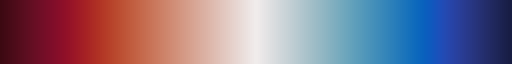

In [14]:
cmap_anom = cmo.balance_r
levels = np.arange(-1, 1.05, 0.05)
levels_fsalt = np.arange(-0.000001, 0.00000101, 0.00000005)
cmap_anom

0
1
2
3


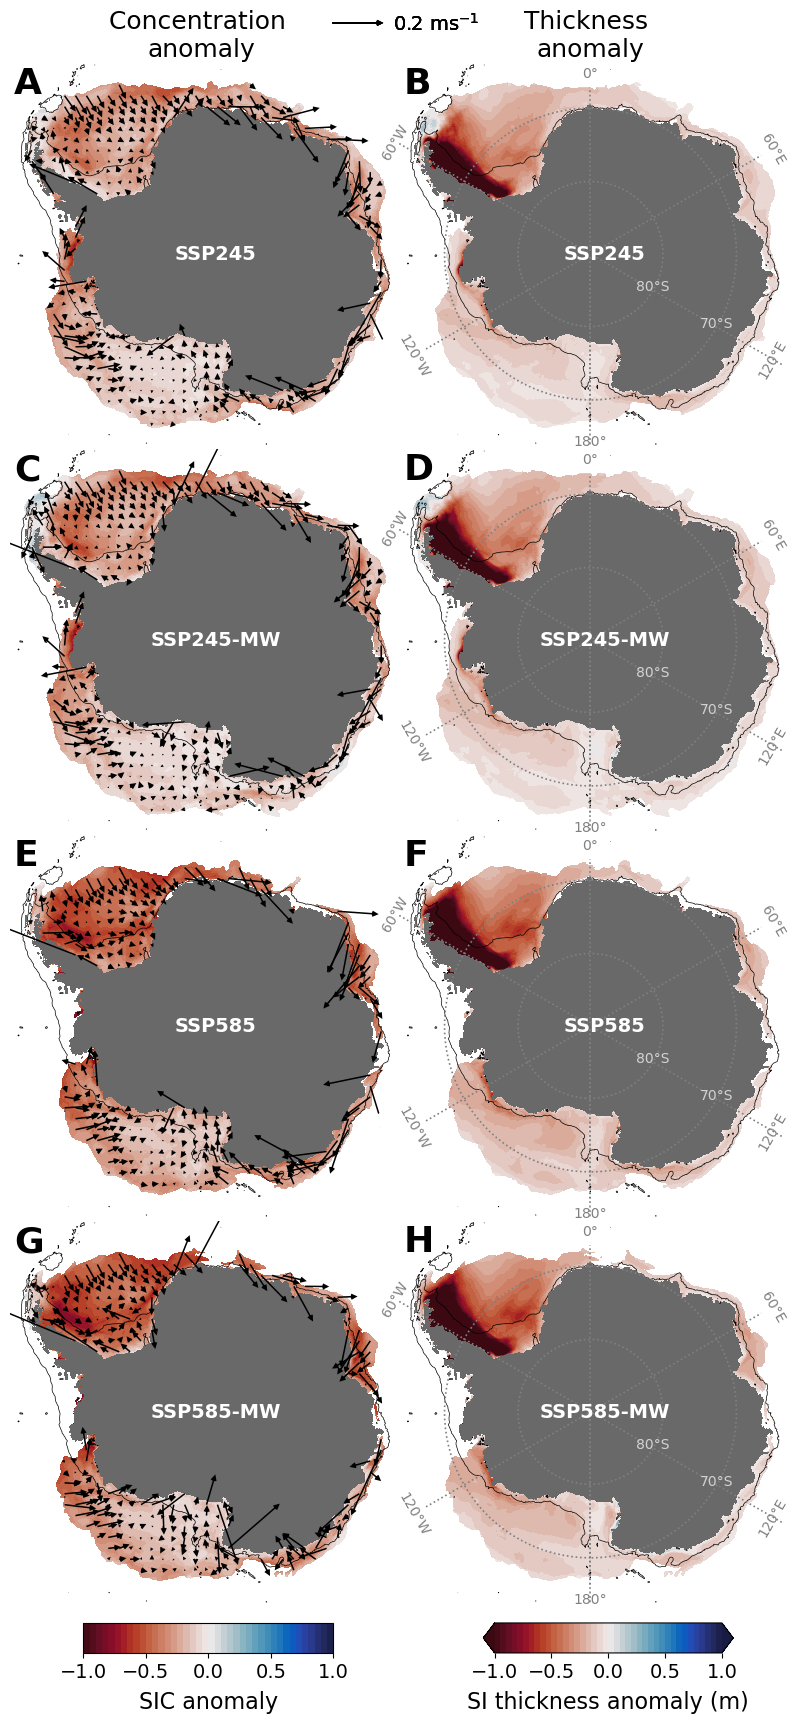

CPU times: user 12min 25s, sys: 1min 45s, total: 14min 10s
Wall time: 12min 45s


In [16]:
%%time
xt_ocean = aice_ctrl_clim.xt_ocean
yt_ocean = aice_ctrl_clim.yt_ocean
plot_season='MAM'
vmin, vmax = -1, 1
vmin_fsalt, vmax_fsalt = -1, 1
# for sea ice vectors
dx = 1 
X, Y = uvel_ctrl.xt_ocean.values[::dx], uvel_ctrl.yt_ocean.values[::dx]

fig, axes = seaice_maps_all_figure()

for r in range(4):
    print(r)
    # plot sea ice conc anomaly
    expt_data = list_expts[f'{expts[r]}']['aice'].sel(season=plot_season)
    expt_data = expt_data.where(expt_data >= 0.05, np.nan)
    anom = expt_data - aice_ctrl_clim.sel(season=plot_season)
    cb = axes[r,0].contourf(xt_ocean, yt_ocean, anom, cmap=cmap_anom, vmin=vmin, vmax=vmax, 
                            levels=levels, transform=ccrs.PlateCarree())

    # plot sea ice thickness anomaly
    expt_hi_data = list_expts[f'{expts[r]}']['hi'].sel(season=plot_season)
    expt_hi_data = expt_hi_data.where(expt_data >= 0.05, np.nan)
    anom = expt_hi_data - hi_ctrl_clim.sel(season=plot_season)
    cbT = axes[r,1].contourf(xt_ocean, yt_ocean, anom, cmap=cmap_anom, vmin=vmin, vmax=vmax, 
                             levels=levels, extend='both', transform=ccrs.PlateCarree())
    
    # plot sea ice vectors
    x_arr_ctrl = uvel_ctrl_clim.sel(season=plot_season).where(expt_data >= 0.05, np.nan)[::dx, ::dx].compute()
    y_arr_ctrl = vvel_ctrl_clim.sel(season=plot_season).where(expt_data >= 0.05, np.nan)[::dx, ::dx].compute()
    x_arr_expt = list_expts[f'{expts[r]}']['uvel'].sel(season=plot_season).fillna(0.)[::dx, ::dx].compute()
    y_arr_expt = list_expts[f'{expts[r]}']['vvel'].sel(season=plot_season).fillna(0.)[::dx, ::dx].compute()
    vector_anom_x = x_arr_expt - x_arr_ctrl
    vector_anom_y = y_arr_expt - y_arr_ctrl
    Q = axes[r,0].quiver(X,Y, vector_anom_x, vector_anom_y, regrid_shape=36, transform=ccrs.PlateCarree(),
                     scale=1.5, headwidth=4, headlength=4, width=0.004, color='k', zorder=20)

    qk = axes[r,0].quiverkey(Q, 0.5, 0.9, 0.2, r'0.2 ms$^{-1}$', labelpos='E',
                   coordinates='figure', fontproperties={'size':14})

    # Draw gridlines
    axes[r,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1.2, xlocs=range(-180, 181, 60), ylocs=[-80,-70,], 
                 color='grey', alpha=1, linestyle=':', rotate_labels=False, )
    # plot latitude labels
    axes[r,1].text(120, -80, '80\u00b0S', ha='center', color='lightgrey', fontsize=10, transform=ccrs.PlateCarree())
    axes[r,1].text(120, -70, '70\u00b0S', ha='center', color='lightgrey', fontsize=10, transform=ccrs.PlateCarree())
    
    plot_text([120, -61], [120, -61], axes[r,1], 60, str(120)+"°E") 
    t = plot_text([60, -62], [60, -62], axes[r,1], -60, str(60)+"°E")
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    
    t = plot_text([-60, -60], [-60, -60], axes[r,1], 60, str(60)+"°W") 
    #t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    t = plot_text([-120, -60], [-120, -60], axes[r,1], -60, str(120)+f"°W\n")
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    
    t = plot_text([0, -65.9], [0, -65.9], axes[r,1], 0, str(0)+"°") 
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    t = plot_text([180, -64], [180, -64], axes[r,1], 0, str(180)+"°")
    t.set_bbox(dict(facecolor='w', alpha=0.2, edgecolor='w'))


cbar = colorbar_horz(cb, [0.2, 0.085, 0.25, 0.015],'SIC anomaly')
cbar = colorbar_horz(cbT, [0.6, 0.085, 0.25, 0.015],'SI thickness anomaly (m)')

# save figure
fig.savefig(f'../figs/SuppFigS2_seaconc_thickness_stereo_{plot_season}_005SICthreshold.jpg', dpi=300, bbox_inches='tight')

plt.show()